In [1]:
import numpy as np
import pandas as pd
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from scipy import special

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = True

In [40]:
bounds = {'pi': {'max': 0, 'min':-35, 'dim':35}, 'phi': {'max': 0, 'min':-.5, 'dim':8}, 
          'theta': {'max':4, 'min': 0, 'dim':12}}

In [41]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.01,
               'log_scale': np.log(252 * 1.564e-5),
                'logit_rho': special.logit(.8)
                }
    
    true_params['log_both'] = np.log(0.6475) + true_params['log_scale']
                
else:

#     Daily
     true_params ={'log_both': -3,
                   'log_scale': -2.3,
                   'logit_rho': special.logit(.6),
                   'phi': -0.3,
                    'pi': -2.3, 
                   'theta': 0.15}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 2000
sim_dim = 1000
innov_dim = 1800

In [42]:
total_true_params = true_params.copy()
total_true_params['psi'] = vl.compute_psi(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                          theta=true_params['theta'])
total_true_params['beta'] = vl.compute_beta(logit_rho=true_params['logit_rho'], 
                                            log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'])
total_true_params['gamma'] = vl.compute_gamma(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'], log_both=true_params['log_both'])
total_true_params['zeta'] = 1 - true_params['phi']**2                                           

In [43]:
vl.compute_moments(psi=total_true_params['psi'], log_scale=true_params['log_scale'],
                   log_both=true_params['log_both'], logit_rho=true_params['logit_rho'],
                   pi=true_params['pi'], phi=true_params['phi'], theta=true_params['theta'])

{'return_mean': 0.016279885604144832,
 'return_var': 0.013096576986779667,
 'vol_mean': 0.012759894000000006,
 'vol_var': 0.0002514515751216002}

In [10]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [11]:
data.describe()

,vol,rtn
count,2000.000000,2000.000000
mean,0.013154,0.016675
std,0.017343,0.116343
min,0.000010,-0.669727
25%,0.002069,-0.034231
50%,0.006272,0.006039
75%,0.016787,0.059054
max,0.137653,0.681116


In [12]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': 1.155240016994922,
 'beta': 0.09722424544370156,
 'gamma': 0.000298574376639809,
 'zeta': 0.9999}

In [13]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [14]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': 1.155240016994922,
 'beta': 0.09722424544370156,
 'gamma': 0.000298574376639809,
 'zeta': 0.9999}

In [15]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [16]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

## We start by examining the distributions of simulated data

In [17]:
data.corr()

,vol,rtn
vol,1.000000,0.148227
rtn,0.148227,1.000000


In [18]:
data.head()

,vol,rtn
2000-01-01,0.002329,0.007457
2000-01-02,0.000610,-0.025330
2000-01-03,0.000116,-0.006529
2000-01-04,0.002083,-0.004289
2000-01-05,0.012883,-0.042333


In [19]:
data.vol.var()

0.00030078517732735373

In [44]:
vl.compute_vol_gmm(data.vol)

({'log_both': -5.99551417294722,
  'log_scale': -5.396808738978411,
  'logit_rho': 1.446022820131903},
            log_both  log_scale  logit_rho
 log_both   0.006738   0.001247  -0.007661
 log_scale  0.001247   0.002417  -0.000388
 logit_rho -0.007661  -0.000388   0.022043)

In [45]:
omega, omega_cov = vl.estimate_params(data)

In [46]:
omega

{'gamma': -0.0005975665516943248,
 'beta': 0.15737202727729147,
 'psi': 1.1555191805276612,
 'zeta': 0.9833606300135945,
 'log_both': -5.99551417294722,
 'log_scale': -5.396808738978411,
 'logit_rho': 1.446022820131903}

In [47]:
omega_cov

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.023730,-5.926246e-05,0.000000,0.000000,0.000000,-0.019228,0.000000
gamma,-0.000059,3.874246e-07,0.000000,0.000000,0.000000,0.000030,0.000000
log_both,0.000000,0.000000e+00,0.006738,0.001247,-0.007661,0.000000,0.000000
log_scale,0.000000,0.000000e+00,0.001247,0.002417,-0.000388,0.000000,0.000000
logit_rho,0.000000,0.000000e+00,-0.007661,-0.000388,0.022043,0.000000,0.000000
psi,-0.019228,2.982749e-05,0.000000,0.000000,0.000000,0.054401,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000978


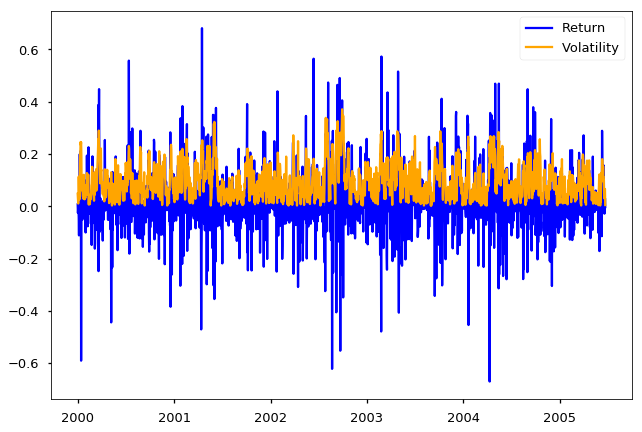

In [48]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [49]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.004257,0.001188
rtn,0.001188,0.013536


In [50]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': 1.155240016994922,
 'beta': 0.09722424544370156,
 'gamma': 0.000298574376639809,
 'zeta': 0.9999}

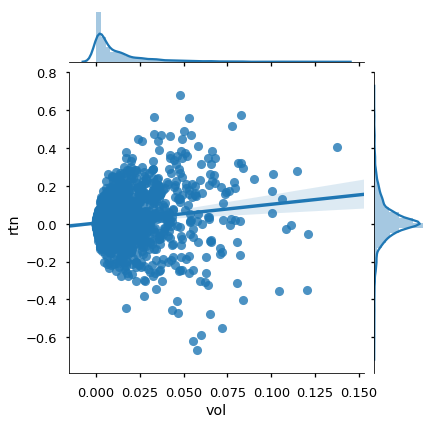

In [51]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [52]:
data.describe()

,vol,rtn
count,2000.000000,2000.000000
mean,0.013154,0.016675
std,0.017343,0.116343
min,0.000010,-0.669727
25%,0.002069,-0.034231
50%,0.006272,0.006039
75%,0.016787,0.059054
max,0.137653,0.681116


## I now estimate all of the parameters

In [53]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [54]:
vl.compute_init_constants(data.vol)

{'log_both': -5.922977588951511,
 'log_scale': -5.370657110665328,
 'logit_rho': 1.364499972731954}

In [31]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [32]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [33]:
vl.compute_init_constants(data.vol)

{'log_both': -5.922977588951511,
 'log_scale': -5.370657110665328,
 'logit_rho': 1.364499972731954}

In [34]:
vl.compute_vol_gmm(data_arr[0].vol)

({'log_both': -5.897508662975594,
  'log_scale': -5.566459503995611,
  'logit_rho': 1.2672674052910922},
            log_both  log_scale  logit_rho
 log_both   0.005322   0.001065  -0.005854
 log_scale  0.001065   0.001708  -0.000776
 logit_rho -0.005854  -0.000776   0.015543)

In [35]:
# with Pool(8) as pool:
#     est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vl.compute_vol_gmm, [data.vol for data in data_arr]),
#                                       total=len(data_arr)))

In [36]:
vol_params = pd.Series(true_params).loc[['log_both', 'log_scale', 'logit_rho']]

In [55]:
estimator = partial(vl.estimate_params_strong_id, bounds=bounds)

In [56]:
estimator(data_arr[0])

({'gamma': 0.0007576154648166211,
  'beta': -0.052004375634090355,
  'psi': 1.4123796195745792,
  'zeta': 0.9615989319044903,
  'log_both': -5.897508662975594,
  'log_scale': -5.566459503995611,
  'logit_rho': 1.2672674052910922,
  'phi': -0.004743170996040127,
  'pi': 0.0,
  'theta': 1.9213995514935358},
                beta         gamma  log_both  log_scale  logit_rho  \
 beta       0.012867 -4.192235e-05  0.000000   0.000000   0.000000   
 gamma     -0.000042  4.195250e-07  0.000000   0.000000   0.000000   
 log_both   0.000000  0.000000e+00  0.005322   0.001065  -0.005854   
 log_scale  0.000000  0.000000e+00  0.001065   0.001708  -0.000776   
 logit_rho  0.000000  0.000000e+00 -0.005854  -0.000776   0.015543   
 phi             NaN           NaN       NaN        NaN        NaN   
 pi              NaN           NaN       NaN        NaN        NaN   
 psi       -0.009508  8.321422e-06  0.000000   0.000000   0.000000   
 theta           NaN           NaN       NaN        NaN        

In [57]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [58]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [59]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_both=true_params['log_both'],
                                                   logit_rho=true_params['logit_rho'], 
                                                   log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

In [60]:
rf_names = ['log_scale', 'logit_rho', 'log_both', 'beta', 'gamma', 'zeta', 'psi']

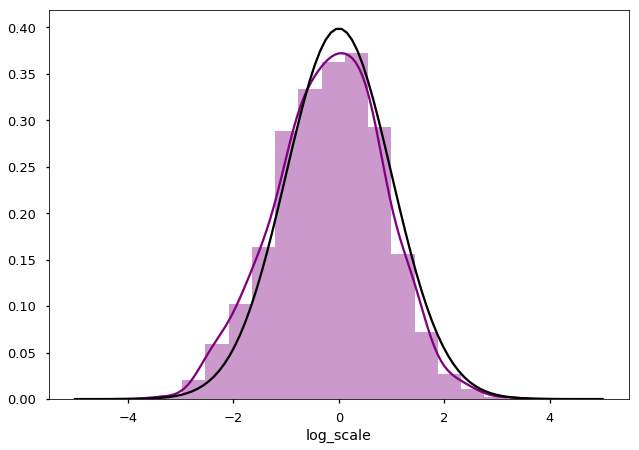

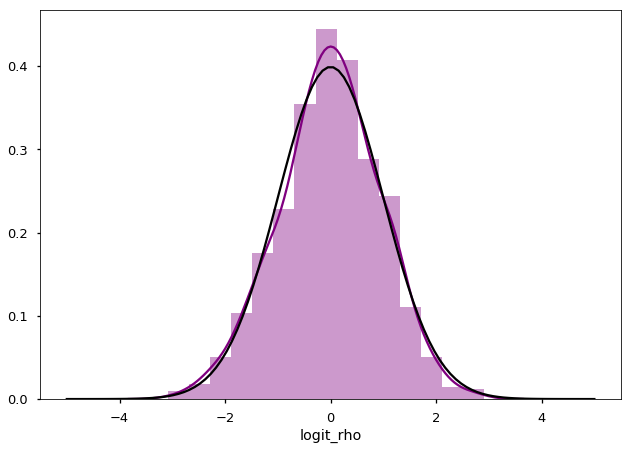

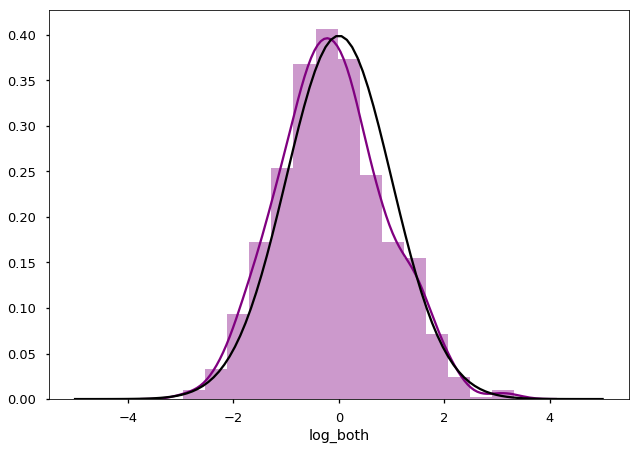

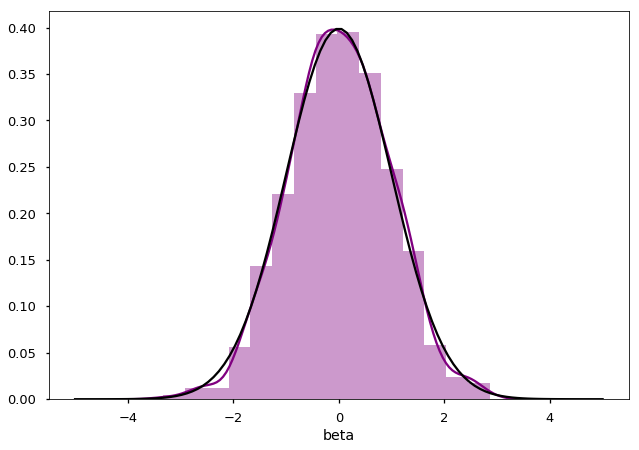

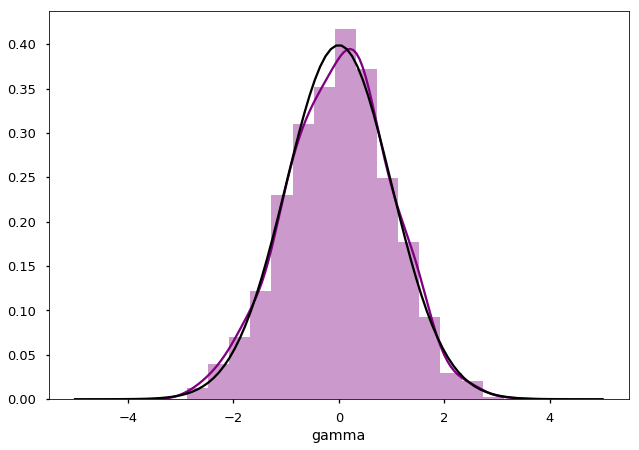

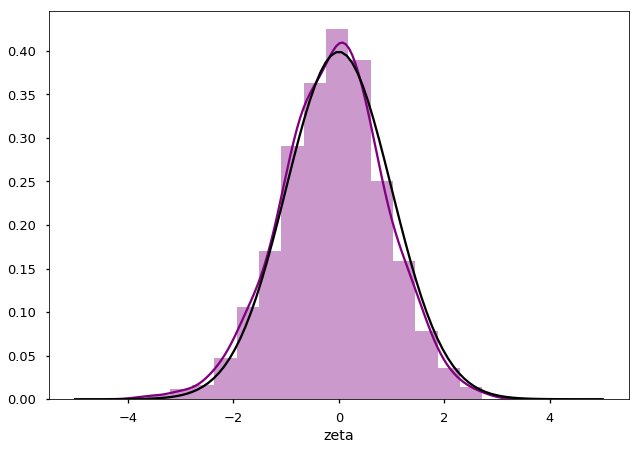

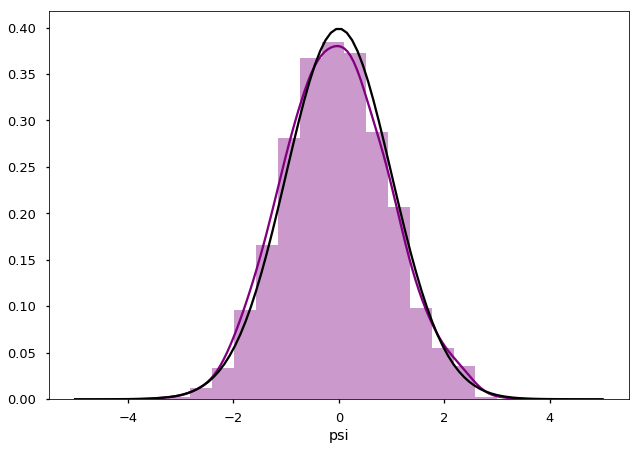

In [61]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in rf_names:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=15, color='purple')
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

In [62]:
def link_function_t_stats(est):
    params = est[0]
    st_params = total_true_params['phi'], total_true_params['pi'], total_true_params['theta']
    rf_names = ['beta', 'gamma', 'log_both', 'log_scale', 'logit_rho', 'psi', 'zeta']
    link = vl.link_total(*st_params, params['beta'], params['gamma'], params['log_both'], params['log_scale'],
                        params['logit_rho'], params['psi'], params['zeta'])
    cov_in = est[1].loc[rf_names, rf_names]
    
    cov = vl._covariance_kernel(*st_params, *st_params, params['log_both'], params['log_scale'],
                                params['logit_rho'],cov_in , params['psi'])
    
    return link /  np.diag(cov)**.5

In [63]:
link_t_stats = np.array([link_function_t_stats(est) for est in tqdm.tqdm_notebook(est_arr)])

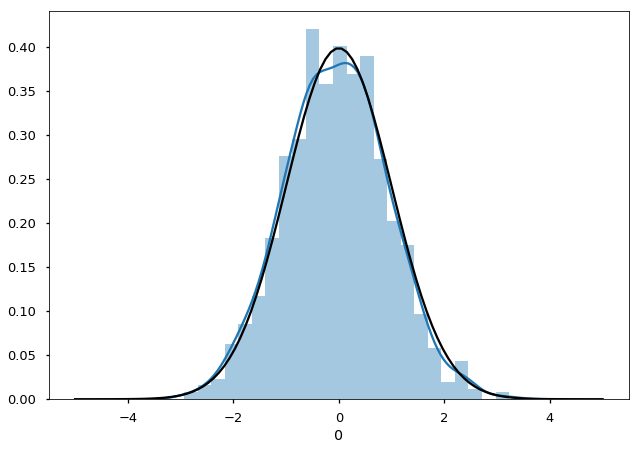

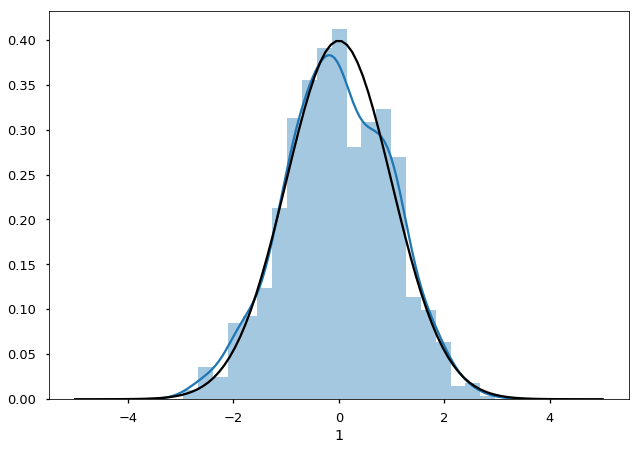

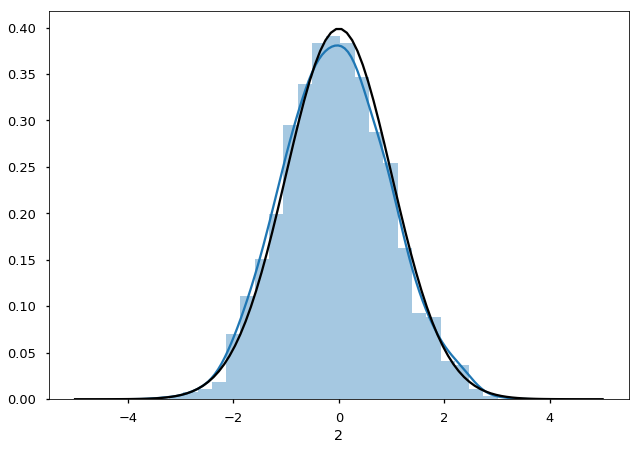

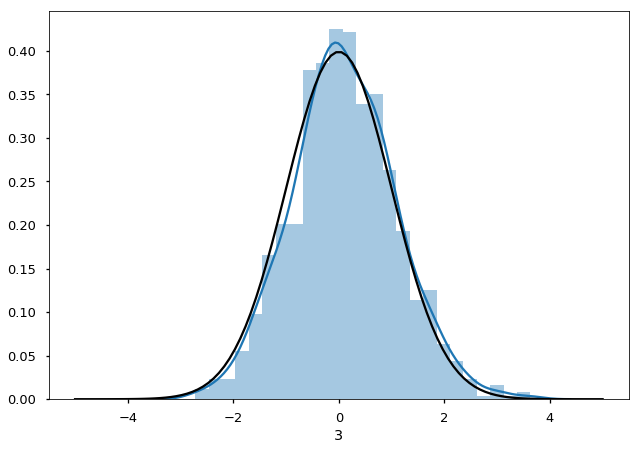

In [64]:
for key, col in enumerate(link_t_stats.T):
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(col, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

    ax.set_xlabel(key)

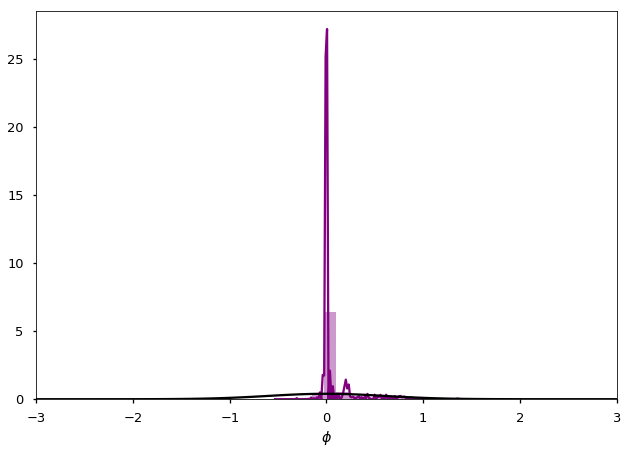

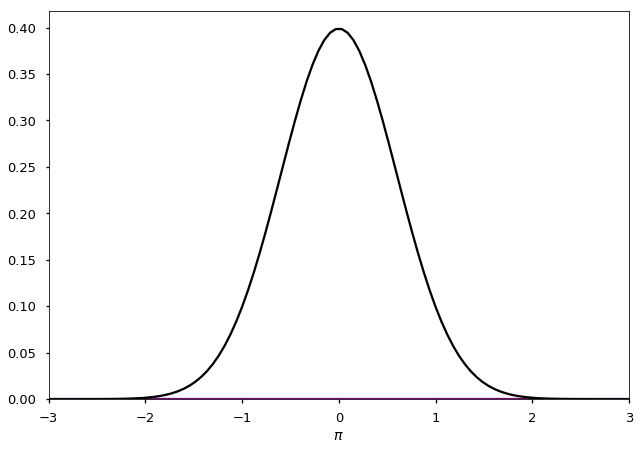

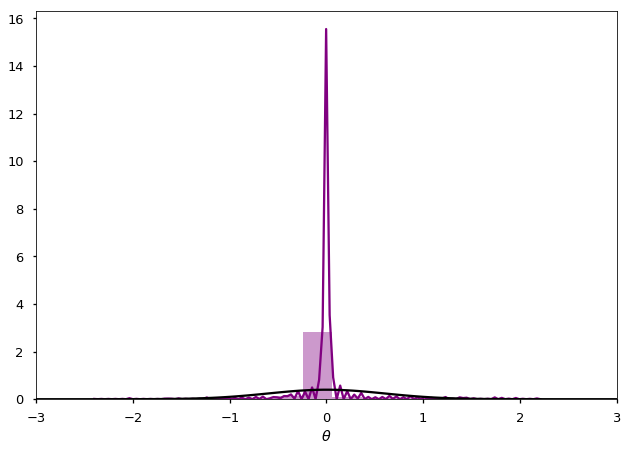

In [65]:
for name in ['phi', 'pi', 'theta']:
    fig, ax = mpl.pyplot.subplots()       
    sns.distplot(pd.Series([(est[name] - true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=15, color='purple')
    ax.plot(np.linspace(-3,3,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

    ax.set_xlabel(f"$\{name}$")
    ax.set_xlim([-3, 3])
    fig.savefig(f"../doc/figures/{name}_est_{innov_dim}_" + "{:.2f}".format(true_params['phi']).replace(
        ".", "_point_").replace("-", "minus_") + ".tmp.pdf", frameon=False, pad_inches=0,
                bbox_inches='tight', transparent=True)

# I now compute the robust conditional QLR statistic 

In [ ]:
omega

In [ ]:
true_params

In [ ]:
def compute_ar(params):
    param_est, param_cov = params
    names = vl.compute_names()
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov)

In [ ]:
param_est, param_cov = est_arr[0]
names = vl.compute_names()
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]

In [ ]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('Anderson-Rubin Statistic Distribution')
    ax.set_xlim(0, 50)
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='black')
    ax.axvline(np.percentile(ar_results, 95), color='blue')
    sns.distplot(ar_results, ax=ax)

In [ ]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=innov_dim, alpha=None, robust_quantile=True, bounds=bounds)

In [ ]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, 
                                        robust_quantile=True, bounds=bounds)

In [ ]:
np.all(returnval.robust_qlr_qauntile == 0)

In [ ]:
returnval.mean()

In [ ]:
np.percentile(returnval.qlr_stat, 95)

In [ ]:
true_params['phi']

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], time_dim)
    
returnval.to_json(filename)

In [ ]:
returnval.mean()

In [ ]:
returnval

In [ ]:
returnval.query('robust_qlr_qauntile > 0').mean()

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)